In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import yaml
import joblib
import json

## 1 Config

In [4]:
cd ..

C:\Users\choisuren.m\Work 2022\MLOps\DVC\start2\dvc-start


In [5]:
with open ("params.yaml") as conf_file:
    config=yaml.safe_load(conf_file)
print(config)

{'base': {'project': '7labs/dvc-2-iris-demo', 'name': 'iris', 'tags': ['solution-0-prototype', 'dev'], 'model': {'model_name': 'model.joblib', 'models_folder': 'models'}, 'experiments': {'experiments_folder': 'experiments'}, 'random_state': 42}, 'split_train_test': {'folder': 'experiments', 'train_csv': 'data/processed/train_iris.csv', 'test_csv': 'data/processed/test_iris.csv', 'test_size': 0.2}, 'featurize': {'dataset_csv': 'data/raw/iris.csv', 'featured_dataset_csv': 'data/interim/featured_iris.csv', 'features_columns_range': ['sepal_length', 'petal_length_to_petal_width'], 'target_column': 'target'}, 'train': {'cv': 5, 'estimator_name': 'svm', 'estimators': {'logreg': {'param_grid': {'C': [0.001, 0.01], 'max_iter': [100], 'solver': ['lbfgs'], 'multi_class': ['multinomial']}}, 'svm': {'param_grid': {'C': [0.1, 1.0], 'kernel': ['rbf', 'linear'], 'gamma': ['scale'], 'degree': [3, 5]}}}}, 'data': {'dataset_csv': 'data/raw/iris.csv', 'features_path': 'data/processed/featured_iris.csv', 

# Load dataset

In [6]:
# Get data 

import pandas as pd
from sklearn.datasets import load_iris

data = load_iris(as_frame=True)
dataset = data.frame
dataset.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [7]:
# print labels for target values 

[print(f'{target}: {label}') for target, label in zip(data.target.unique(), data.target_names)]

0: setosa
1: versicolor
2: virginica


[None, None, None]

In [8]:
# feature names

dataset.columns = [colname.strip(' (cm)').replace(' ', '_') for colname in dataset.columns.tolist()]

feature_names = dataset.columns.tolist()[:4]
feature_names

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [9]:
#  Save raw data
dataset.to_csv(config["data"]["dataset_csv"], index=False)

# Features engineering

In [10]:
dataset['sepal_length_to_sepal_width'] = dataset['sepal_length'] / dataset['sepal_width']
dataset['petal_length_to_petal_width'] = dataset['petal_length'] / dataset['petal_width']

dataset = dataset[[
    'sepal_length', 'sepal_width', 'petal_length', 'petal_width',
#     'sepal_length_in_square', 'sepal_width_in_square', 'petal_length_in_square', 'petal_width_in_square',
    'sepal_length_to_sepal_width', 'petal_length_to_petal_width',
    'target'
]]

In [11]:
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,sepal_length_to_sepal_width,petal_length_to_petal_width,target
0,5.1,3.5,1.4,0.2,1.457143,7.0,0
1,4.9,3.0,1.4,0.2,1.633333,7.0,0
2,4.7,3.2,1.3,0.2,1.468750,6.5,0
3,4.6,3.1,1.5,0.2,1.483871,7.5,0
4,5.0,3.6,1.4,0.2,1.388889,7.0,0


In [12]:
#features_path='data/processed/featured_iris.csv'
#dataset.to_csv(features_path,index=False)

In [13]:
dataset.to_csv(config["data"]["features_path"], index=False)

# Split dataset

In [14]:
test_size=0.2

## Splittail train/test

In [15]:
train_dataset, test_dataset = train_test_split(dataset, test_size=test_size, random_state=42)
train_dataset.shape, test_dataset.shape

((120, 7), (30, 7))

In [16]:
# Save train and test 
#trainset_path='data/processed/train_iris.csv'
#testset_path='data/processed/test_iris.csv'

train_dataset.to_csv(config["data"]["trainset_path"])
test_dataset.to_csv(config["data"]["testset_path"])

# Train

In [24]:
# Get X and Y

y_train = train_dataset.loc[:, 'target'].values.astype('int32')
X_train = train_dataset.drop('target', axis=1).values.astype('float32')

In [25]:
# Create an instance of Logistic Regression Classifier CV and fit the data

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

c:\users\choisuren.m\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [22]:
model_path='models/model.joblib'
#joblib.dump(logreg,config["train"]["model_path"])

# Evaluate

In [26]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [27]:
# Get X and Y

y_test = test_dataset.loc[:, 'target'].values.astype('int32')
X_test = test_dataset.drop('target', axis=1).values.astype('float32')

In [28]:
prediction = logreg.predict(X_test)
cm = confusion_matrix(prediction, y_test)
f1 = f1_score(y_true = y_test, y_pred = prediction, average='macro')

In [29]:
# f1 score value
f1

1.0

In [30]:
metrics={'f1':f1}

In [32]:
#with open(config["reports"]["metrics_file"],'w') as mf:
#    json.dump(obj=metrics,fp=mf,indent=4)

In [45]:
import seaborn as sns

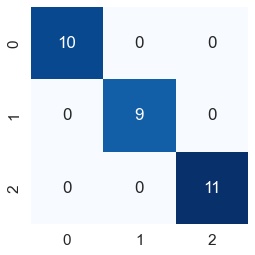

In [47]:
plt=sns.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.figure.savefig('file.png')

In [23]:
#cm_plot.savefig(config["reports"]["confusion_matrix.png"])